

---
# **Iris dataset**

🙋‍♀️ Author : Sonia firdous

📧 Email: soniafirdous1985@gmail.com

🔗 Data Source :

The data was collected from the seaborn datasets

🎯 Purpose of Analysis – Iris Dataset

The Iris dataset is one of the most well-known datasets in machine learning and statistics. It contains measurements of four flower features — sepal length, sepal width, petal length, and petal width — across three species: Setosa, Versicolor, and Virginica.

The purpose of this analysis is to:

Explore the dataset (EDA) → understand feature distributions, relationships, and outliers.

Build a classification model → train a Decision Tree to predict the species of an iris flower based on its features.

Evaluate performance → measure accuracy, precision, recall, and f1-score to assess how well the model distinguishes between the three species.

Gain insights → identify which features (like petal length/width) are most important in differentiating species.

Ultimately, this analysis demonstrates how supervised machine learning can classify biological data, while also showcasing the strengths and limitations of Decision Trees.

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



In [63]:
# load iris dataset
iris = sns.load_dataset("iris")

print(iris.head())


   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [64]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [65]:
iris.dtypes

,0
sepal_length,float64
sepal_width,float64
petal_length,float64
petal_width,float64
species,object


In [66]:
iris["species"].value_counts()

,count
species,
setosa,50
versicolor,50
virginica,50


missing values

In [67]:
iris.isnull().sum()

,0
sepal_length,0
sepal_width,0
petal_length,0
petal_width,0
species,0


duplicated rows

In [68]:
iris.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
145,False
146,False
147,False
148,False


distribution of features

In [69]:
iris.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


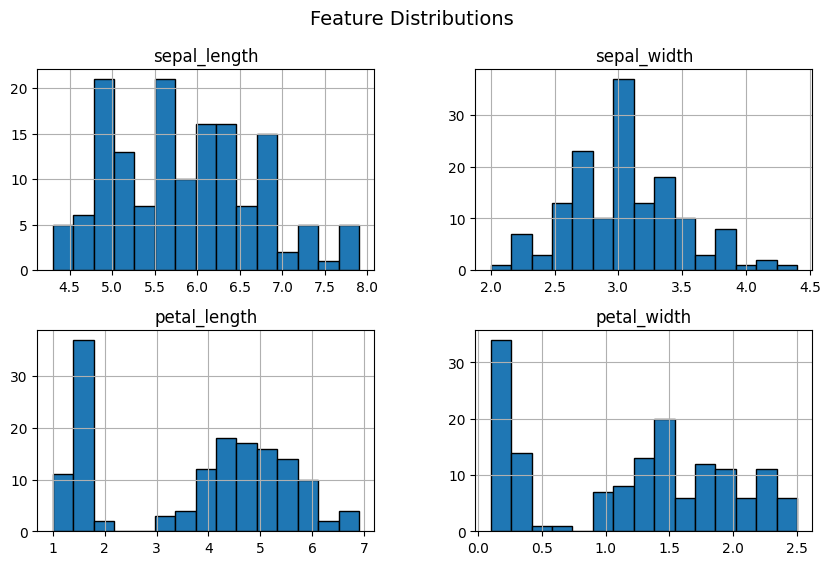

In [70]:
iris.hist(figsize=(10,6), bins=15, edgecolor="black")
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()


pairplot to check relationships b/w features

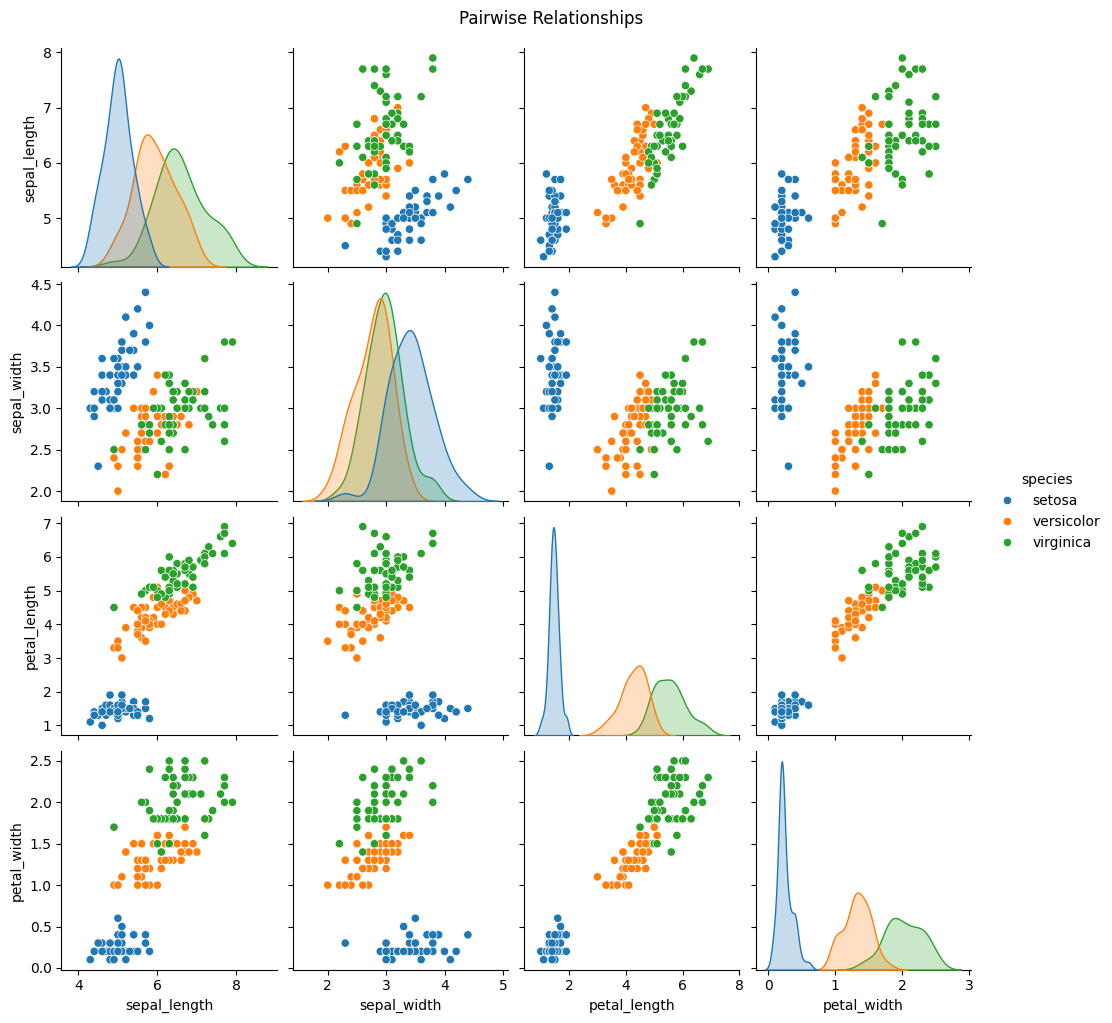

In [71]:
sns.pairplot(iris, hue="species", diag_kind="kde")
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()


correlation heat map

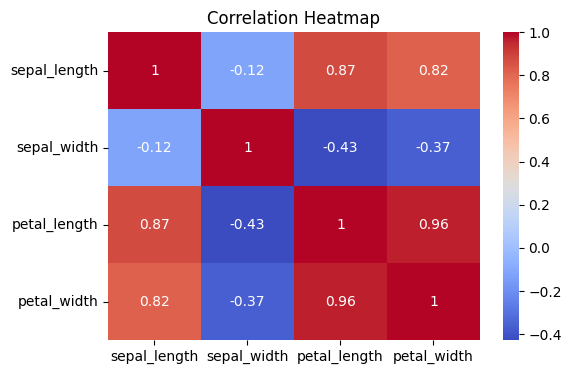

In [72]:
plt.figure(figsize=(6,4))
sns.heatmap(iris.drop("species", axis=1).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

box plot to find outliers

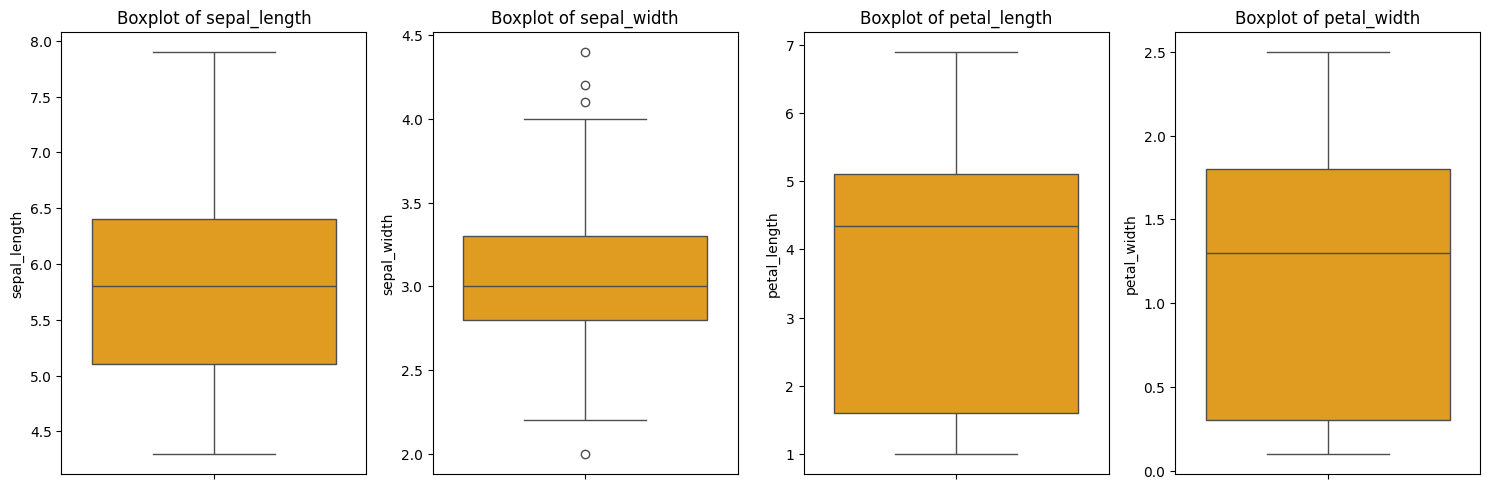

In [73]:
# Create subplots
fig, axes = plt.subplots(1, len(iris.columns[0:-1]), figsize=(15, 5))

# Loop through columns and plot on subplots
for i, col in enumerate(iris.columns[0:-1]):
    sns.boxplot(y=iris[col], ax=axes[i], color="orange")
    axes[i].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

oulier summary

In [74]:
def outlier_summary_iqr(df):
    summary = []
    n = len(df)

    for col in df.select_dtypes(include=['float64','int64']).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)][col]
        count = len(outliers)
        perc = (count / n) * 100

        summary.append({
            "Column": col,
            "Outlier_Count": count,
            "Outlier_%": round(perc, 2)
        })

    return pd.DataFrame(summary)

In [75]:
outlier_summary_iqr(iris)

,Column,Outlier_Count,Outlier_%
0,sepal_length,0,0.00
1,sepal_width,4,2.67
2,petal_length,0,0.00
3,petal_width,0,0.00


outlier removal

✅ Rule of thumb for outliers:

If <5% outliers → usually safe to keep.

If 5–15% outliers → consider capping or transforming.

If >15–20% outliers → investigate closely: maybe distribution is heavy-tailed and needs transformation instead of deletion.

here is a func to remove ouliers but here no need as our outliers are less than 5

In [76]:
def remove_outliers_iqr(df):
    df_clean = df.copy()
    for col in df_clean.select_dtypes(include=['float64','int64']).columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean


In [77]:
iris.shape

(150, 5)

splitting feature into independent and target

In [78]:
x=iris.drop("species",axis=1)
y=iris["species"]

In [79]:
x

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [80]:
y

,species
0,setosa
1,setosa
2,setosa
3,setosa
4,setosa
...,...
145,virginica
146,virginica
147,virginica
148,virginica


train test split

In [81]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y)

modeling

In [82]:
clf = DecisionTreeClassifier()


train model

In [83]:
clf.fit(x_train,y_train)

DecisionTreeClassifier()

prediction              

In [84]:
y_pred=clf.predict(x_test)

evaluation

In [85]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9333333333333333

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



confusion matrix

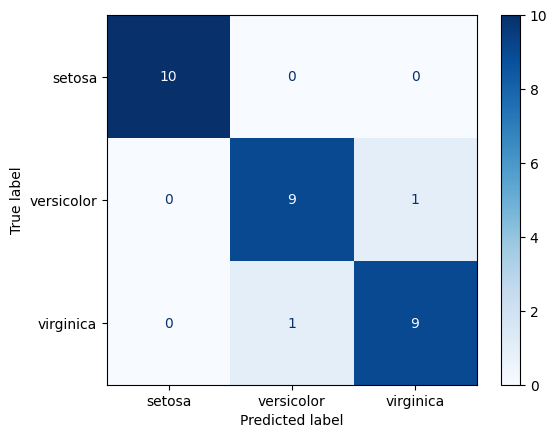

In [86]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap="Blues")
plt.show()


decision tree

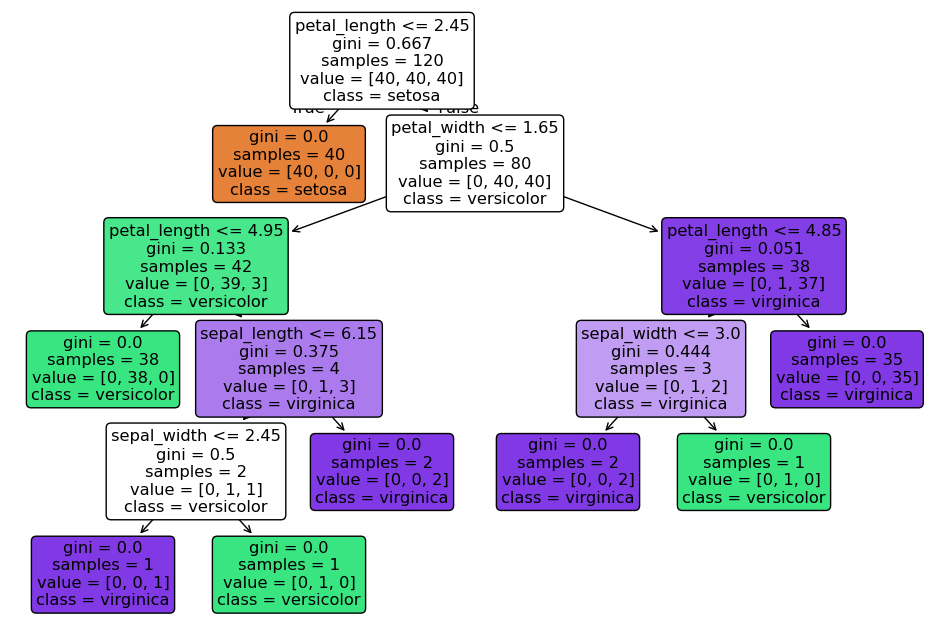

In [87]:
plt.figure(figsize=(12,8))
plot_tree(clf, feature_names=x.columns, class_names=clf.classes_, filled=True, rounded=True)
plt.show()

applying grid search cv

parameter grid for Decision Tree

In [88]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [2, 3, 4, 5, None],
    "min_samples_split": [2, 3, 4, 5],
    "min_samples_leaf": [1, 2, 3]}

Initialize Decision Tree & GridSearchCV



In [89]:
clf = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, None],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='accuracy')

Best parameters & best score

In [90]:
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation Accuracy: 0.9416666666666668


Evaluate on test set

In [91]:
best_clf = grid.best_estimator_
y_pred = best_clf.predict(x_test)

In [92]:
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.9333333333333333

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



Visualize the best decision tree

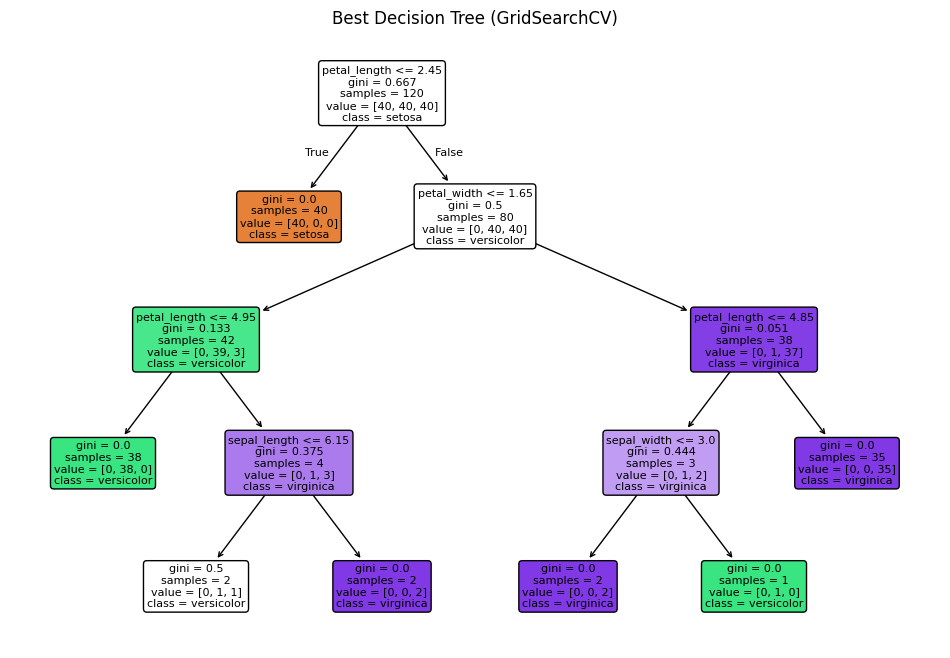

In [93]:
plt.figure(figsize=(12,8))
plot_tree(best_clf, feature_names=x.columns, class_names=best_clf.classes_,
          filled=True, rounded=True, fontsize=8)
plt.title("Best Decision Tree (GridSearchCV)")
plt.show()

# 📌Conclusion
The Decision Tree classifier achieved an overall accuracy of ~93% on the test set.

Setosa was classified with perfect precision and recall (100%), showing it is the easiest class to separate.

Versicolor and Virginica reached 90% precision and recall, indicating some misclassifications between these two species (which are known to be more similar).

The macro and weighted averages (93%) confirm consistent performance across all classes.

Overall, the model performs well on the Iris dataset, but slight confusion between versicolor and virginica suggests that a more powerful models could further improve results.